# **TikTok Project**
**Classification model to determine whether a video contains a claim or whether it offers an opinion.**


**The purpose** of this model is to increase response time and system efficiency by automating the initial stages of the claims process.

**The goal** of this model is to predict whether a TikTok video presents a "claim" or presents an "opinion".
<br/>

*We will be performing the following three parts:*

**Part 1:** EDA 

* Carry out Exploratory Data Analysis and define the objective of the model. 

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models (Random Forest and XGBoost), evaluate them, and advise on next steps


### **Task 1. Imports and data loading** 

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier  

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import pickle 
import time   

pd.set_option('display.max_columns', None)

In [ ]:
data = pd.read_csv("tiktok_dataset.csv")
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


### **Examine data, summary info, and descriptive stats**

In [ ]:
data.shape

(19382, 12)

In [ ]:
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


The descriptive statistics of the dataset suggest that no extreme outliers exist within the features we will later use for modelling.
Furthermore no negative values are present in count features which wouldn't make sense and would need filtering out.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [ ]:
#Get rid of null values as they form only 1% of our dataset
data=data.dropna(axis=0)
data.shape

(19084, 12)

In [ ]:
if data.drop_duplicates().shape[0]==len(data):
    print('No duplicates in our dataset')
else:
    print(f'{len(data)-data.drop_duplicates().shape[0]} duplicates were found in the dataset. Please remove')

No duplicates in our dataset


Check class balance.

In [ ]:
data['claim_status'].value_counts(normalize = True)

claim_status
claim      0.503458
opinion    0.496542
Name: proportion, dtype: float64

### **Feature engineering**

In [ ]:
# Calculate the average text_length for claims and opinions
data['length_trans_text']=data['video_transcription_text'].apply(lambda x: len(x))
data.groupby(['claim_status'])['length_trans_text'].mean()

claim_status
claim      95.376978
opinion    82.722562
Name: length_trans_text, dtype: float64

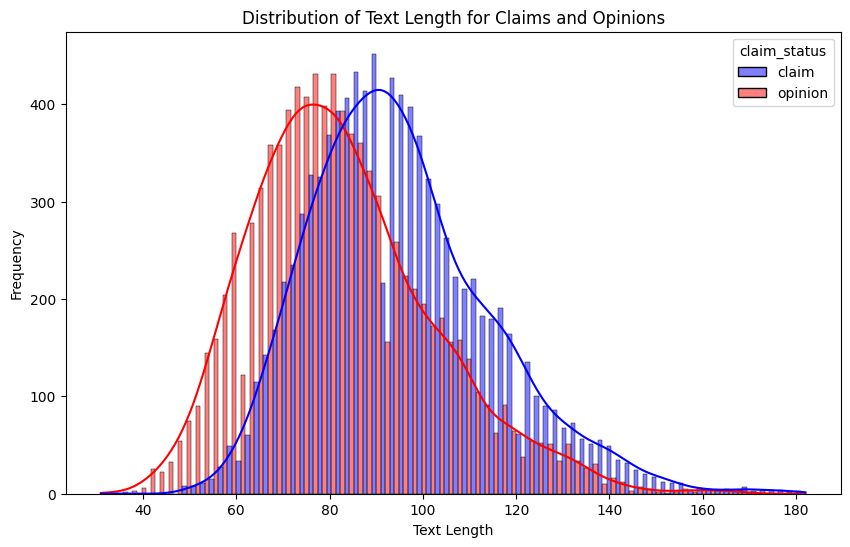

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data= data, 
             x ='length_trans_text',
             color='blue',
             stat = 'count',
             hue='claim_status',
             legend= True,
             palette= ['blue' ,'red'],
             multiple= 'dodge',
             kde=True
            ) 

plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length for Claims and Opinions')

plt.show()

### **Tokenize text column**

 
The feature `video_transcription_text` is text-based. 
One way to extract numerical features from it is through tokenisation.

We will use a bag-of-words algorithm called `CountVectorizer` and we will break each video's transcription text into both 2-grams and 3-grams and use the 15 most frequently occurring tokens from the entire dataset to use as features.

In [ ]:
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_data = count_vec.fit_transform(data['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())
data_final = pd.concat([data.reset_index(drop=True), count_df], axis=1)
data_final.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,length_trans_text,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Encode target and catgorical variables.

In [ ]:
# Encode target variable 
y = pd.get_dummies(data_final['claim_status'],drop_first=True).astype(int)['opinion']  #0--> claim 1 --> opinion
 
X = data_final.copy().drop(columns = 'claim_status') 
unwanted_feats= ['video_id', 'video_transcription_text','#']
X = X.drop(columns= unwanted_feats)

# Dummy encode remaining categorical values
X = pd.get_dummies(X,drop_first=True).astype(int)
X

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,length_trans_text,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,343296,19425,241,1,0,97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,32,140877,77355,19034,1161,684,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31,902185,97690,2858,833,329,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25,437506,239954,34812,1234,584,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,19,56167,34987,4110,547,152,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19079,49,6067,423,81,8,2,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19080,23,2973,820,70,3,0,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19081,50,734,102,7,2,1,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19082,8,3394,655,123,11,4,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### **Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2)
X_train

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,length_trans_text,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager,verified_status_verified,author_ban_status_banned,author_ban_status_under review
16754,6,9158,1478,43,20,1,67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
15097,36,4445,605,80,13,4,118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1491,54,327768,31657,4783,313,15,92,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8261,59,60663,18681,3571,129,75,106,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16221,54,4995,1046,126,26,3,117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7568,16,561846,344496,55380,3718,2230,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3436,13,781833,211960,7456,1341,607,104,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
18455,17,8074,2233,486,17,5,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1702,57,138361,81731,1378,432,6,98,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0


Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size = 0.25, random_state = 4)

sum=0
for set in [X_train, y_train, X_val, y_val,  X_test,  y_test]:
    sum+=(set).shape[0]/len(data)
    
if (sum/2)==1.0 and round(len(y_val)/len(data),1) == 0.2:
    print('Data splitted successfully')
else:
    print(f'Train,test and validation data lengths sum up to {int(len(data)*sum/2)} and not {len(data)}')

Data splitted successfully


### **Build a random forest model**

Below we fit a random forest model to the training set. 
We then use cross-validation to tune the hyperparameters and select the model that performs best on recall.

In [ ]:
# Instantiate the random forest classifier
rf_classifier = RandomForestClassifier()

# Create a dictionary of hyperparameters to tune based on best judgement
cv_params_dict = {'n_estimators': [200],
                  'max_depth': [5,7,None],
                  'max_samples': [0.85],
                  'max_features': [0.85],
                  'min_samples_leaf': [1],
                  'min_samples_split' : [2],
                 }

# Define a dictionary of scoring metrics to capture
scoring_params= ['f1','accuracy','recall','precision']

# Instantiate the GridSearchCV object
cv_rf_classifier = GridSearchCV(estimator=rf_classifier,
                         param_grid=cv_params_dict, 
                         scoring=scoring_params,
                         cv= 4,
                         refit='recall') 

In [ ]:
t = time.time()

cv_rf_classifier.fit(X_train,y_train)
elapsed = time.time() - t

print(f' Best classifier: {cv_rf_classifier.best_estimator_,cv_rf_classifier.best_score_}' 
          f'Time taken: {elapsed}') 

 Best classifier: (RandomForestClassifier(max_depth=5, max_features=0.85, max_samples=0.85,
                       n_estimators=200), 1.0)Time taken: 51.13301157951355


In [ ]:
cv_rf_classifier.best_params_

{'max_depth': 5,
 'max_features': 0.85,
 'max_samples': 0.85,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Define functions to pickle the model for future use

In [ ]:
def write_pickle(path, model_object, save_name:str):
    '''
    save_name is a string.
    '''
    with open(path + save_name + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)
        
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [ ]:
write_pickle(path='home/personal_projects/tiktok', model_object=cv_rf_classifier, save_name='rf_classifier')

In [ ]:
# Get all the results from the CV and put them in a df
results_rf = pd.DataFrame(cv_rf_classifier.cv_results_)
results_rf[results_rf['mean_test_precision']==results_rf['mean_test_precision'].max()]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_samples,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision
2,3.201,0.088493,0.043,0.000736,7,0.85,0.85,1,2,200,"{'max_depth': 7, 'max_features': 0.85, 'max_sa...",0.996845,0.997545,0.997193,0.998244,0.997457,0.000517,1,0.996856,0.997555,0.997205,0.998253,0.997467,0.000516,1,1.0,1.0,1.0,1.0,1.0,0.0,1,0.993711,0.995101,0.994402,0.996494,0.994927,0.00103,1


### **Build an XGBoost model**

In [ ]:
XGB_classifier=XGBClassifier(objective='binary:logistic')

# initial_cv_params={'max_depth' : [3,5], 
# 'min_child_weight': [2,4],
# 'eta' : [0.1,,0.3,0.5,0.7,1,2],
# 'n_estimators': [100]
# }     
best_cv_params={'max_depth' : [5], 
                'min_child_weight': [2],
                'eta' : [0.7],
                'n_estimators': [100],
                } 

scoring_params= ['f1','accuracy','recall','precision']

cv_xgb_classifier = GridSearchCV(estimator=XGB_classifier,
                         param_grid=best_cv_params, 
                         scoring=scoring_params,
                         cv= 4,
                         refit='f1')

t=time.time()
cv_xgb_classifier.fit(X_train,y_train)
elapsed = time.time() - t

print(f' Best classifier: {cv_xgb_classifier.best_estimator_,cv_xgb_classifier.best_score_}' 
    f'/n Time taken: {elapsed}')

 Best classifier: (XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.7, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...), 0.9936139597036193)/n Time taken: 2.63348388671875


In [ ]:
write_pickle(path='home/personal_projects/tiktok', model_object=cv_xgb_classifier, save_name='xgb_classifier')

In [ ]:
results_xgb = pd.DataFrame(cv_xgb_classifier.cv_results_)
results_xgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta,param_max_depth,param_min_child_weight,param_n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,0.447902,0.192969,0.041994,0.002801,0.7,5,2,100,"{'eta': 0.7, 'max_depth': 5, 'min_child_weight...",0.993684,0.99544,0.990589,0.994742,0.993614,0.001855,1,0.993713,0.995459,0.990566,0.994759,0.993624,0.001872,1,0.995781,0.99789,1.0,0.998593,0.998066,0.001522,1,0.991597,0.993002,0.981354,0.990922,0.989219,0.004602,1


### **Evaluate model** 

#### **Random forest**

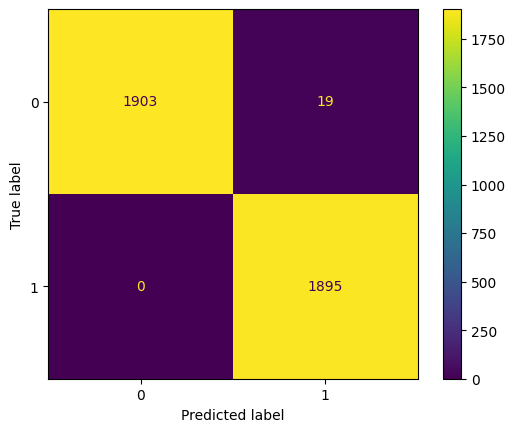

In [ ]:
# Plot confusion matrix for the Test dataset
y_rf_pred = cv_rf_classifier.predict(X_test) 
cm = confusion_matrix(y_test, y_rf_pred, labels=cv_rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=cv_rf_classifier.classes_, 
                             )
disp.plot(values_format='')

#### **XGB model**

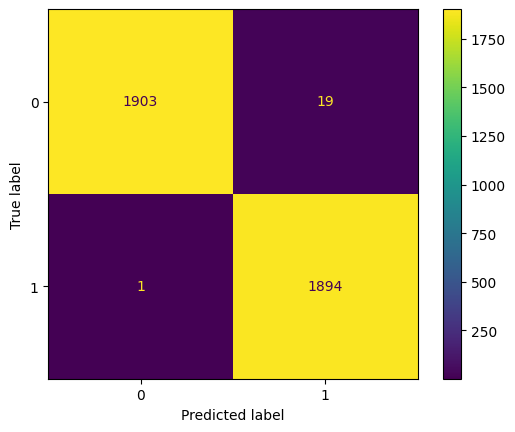

In [ ]:
xgb_pred = cv_xgb_classifier.predict(X_test) 
cm = confusion_matrix(y_test, xgb_pred, labels=cv_xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=cv_xgb_classifier.classes_, 
                             )
disp.plot(values_format='')

Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the model.

In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
    model_name (string): what you want the model to be called in the output table
    model_object: a fit GridSearchCV object
    metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                 'recall': 'mean_test_recall',
                 'f1': 'mean_test_f1',
                 'accuracy': 'mean_test_accuracy',
                 }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                        'precision': [precision],
                        'recall': [recall],
                        'F1': [f1],
                        'accuracy': [accuracy],
                        },
                       )

    return table

In [ ]:
results = pd.concat([make_results('XGB', cv_xgb_classifier, 'f1'),(make_results('Random Forest', cv_rf_classifier, 'f1'))])
results.sort_values('F1',ascending = False).reset_index(drop=True)

,model,precision,recall,F1,accuracy
0,Random Forest,0.994927,1.000000,0.997457,0.997467
1,XGB,0.989219,0.998066,0.993614,0.993624


**Question:** What does your classification report show? What does the confusion matrix indicate?

### **Use champion model to predict on test data**

In [ ]:
champ_model = cv_rf_classifier

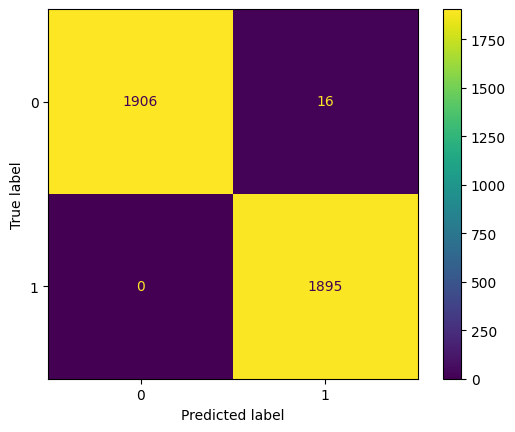

In [ ]:
#Plot confusion matrix
xgb_pred = champ_model.predict(X_val) 
cm = confusion_matrix(y_val, xgb_pred, labels=champ_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=champ_model.classes_, 
                             )
disp.plot(values_format='')

#### **Feature importances of champion model**


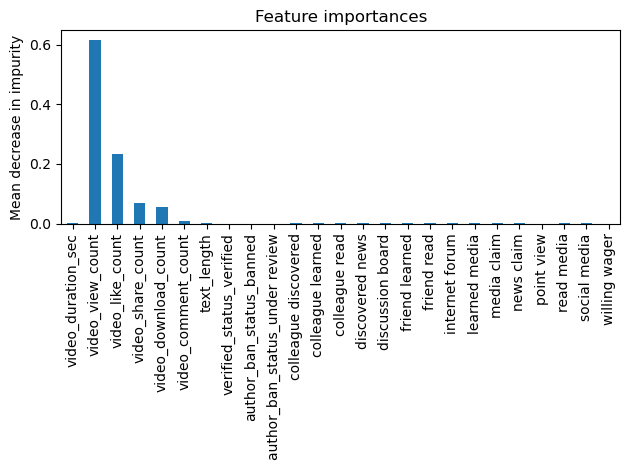

In [ ]:
importances = champ_model.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

### **Conclusion**


1. **Recommendation of the model:**</br>
    One can recommend this model because it performed well on both the validation and test holdout data. Furthermore, both precision and F<sub>1</sub> scores were consistently high. The model very successfully classified claims and opinions.
</br>

2. **Explanation of the model:**</br>
    The model's most predictive features were all related to the user engagement levels associated with each video. It was classifying videos based on how many views, likes, shares, and downloads they received.
    </br>
3. **Additional feature engineering to improve model performance:**</br>   Because the model currently performs nearly perfectly, there is no need to engineer any new features.</br>
    However, it would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author. 
